### Accessing single image using iMap API

### Import necessary libraries

In [76]:
import requests
import pickle
import json
import urllib
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from time import sleep
import os

### Accessing iMapInvasives API https://www.imapinvasives.org/
#### Use your iMap username and password in the code below to get access to the iMap API

In [6]:
import requests

imap_site = "imapinvasives"
iMap_username = "your iMap_username"  # Replcae with your iMap username
iMap_password = "your iMap_password"  # Replace with your iMap password

login_url = r"https://{0}.natureserve.org/imap/j_spring_security_check".format(imap_site)

# Attempt to log in
print("\nAttempting to authenticate with: {0}".format(login_url))
iMapSession = requests.Session()  # This is a global variable accessed in later functions
login_response = iMapSession.post(login_url,{'j_username':iMap_username,'j_password':iMap_password})
login_response_message = "\nlogin response: {0}".format(login_response.status_code)
print(login_response_message)
login_response.raise_for_status()

# Attempt to access a record to check if log-in was successful
test_aoi_url = r"https://{0}.natureserve.org/imap/services/aoi/new".format(imap_site)
test_aoi_record = iMapSession.get(test_aoi_url)
test_aoi_record_message = "\nTest record access response: {0}".format(test_aoi_record.status_code)
print(test_aoi_record_message)

if test_aoi_record.status_code == 403:
    print("\nResponse Code 403 is most likely the result of an incorrectly entered iMap username or password.  It may also be caused by logging in as a user with insufficient permissions.")

test_aoi_record.raise_for_status()


Attempting to authenticate with: https://imapinvasives.natureserve.org/imap/j_spring_security_check

login response: 200

Test record access response: 200


### Identify single iMap record using iNaturalist VisionAPI

In [13]:
presence_id = 1355159 # Change this iMap presence ID number for different iMap image identification

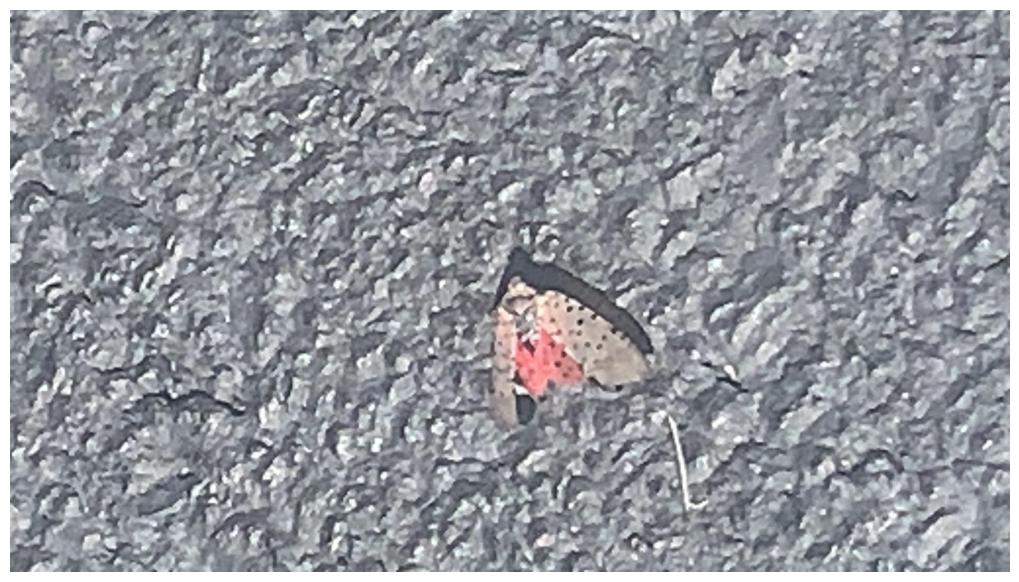

In [27]:
# Function to get the image from a URL, handling redirects and setting headers
def get_image_from_url(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }

    response = iMapSession.get(url, headers=headers, allow_redirects=True)

    if response.status_code == 200:
        try:
            return Image.open(BytesIO(response.content))
        except Exception as e:
            print(f"Failed to open image. Error: {e}")
            return None
    else:
        print(f"Failed to retrieve image. Status code: {response.status_code}")
        return None

# Function to plot images for the specified presence ID
def plot_images_for_species(imap_dictionary, presence_id):
    species_list = imap_dictionary.get("speciesList", [])

    # Process only the first valid image, if available
    for species in species_list:
        if "photos" in species and species["photos"]:
            photo_url = species["photos"][0].get("photoUrl", "")

            if photo_url and (photo_url.lower().endswith('.jpg') or photo_url.lower().endswith('.jpeg')):  # Ensure the URL is a valid .jpg or .jpeg
                img = get_image_from_url(photo_url)
                if img:
                    # Plot the image without extra space
                    fig, ax = plt.subplots(figsize=(10, 10))  # Adjust size as needed
                    ax.imshow(img)
                    ax.axis('off')  # Turn off the axis
                    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove extra space
                    plt.show()
                return  # Stop after the first valid image

    print("No valid images found.")

# Function to process the specified presence ID and plot images
def plot_images_for_single_species_id(presence_id):
    base_url = "https://imapinvasives.natureserve.org/imap/services/presence/"
    # Construct the full URL for the presence ID
    full_url = f"{base_url}{presence_id}"

    # Get the iMap record for this presence ID
    imap_record = iMapSession.get(full_url)

    if imap_record.status_code == 200:
        # Convert the response to a dictionary
        imap_dictionary = imap_record.json()

        # Plot images for this presence ID
        plot_images_for_species(imap_dictionary, presence_id)
    else:
        print(f"Failed to retrieve data for presence ID {presence_id}. Status code: {imap_record.status_code}")

# Example: Process and plot for the given presence_id

plot_images_for_single_species_id(presence_id)


### Use your RapidAPI key for the iNaturalist VisionAPI in the code below

In [29]:
import requests
import json
from PIL import Image
from io import BytesIO
from IPython.display import display, HTML


# Function to extract latitude and longitude from the imap_dictionary
def get_lat_lon_from_imap(imap_dictionary):
    # Check presencePoint first
    presence_point = imap_dictionary.get("presencePoint")
    if presence_point:
        latitude = presence_point.get('latitude')
        longitude = presence_point.get('longitude')
    else:
        # If presencePoint is not available, check presenceLine
        presence_line = imap_dictionary.get("presenceLine")
        if presence_line:
            latitude = presence_line.get('latitude')
            longitude = presence_line.get('longitude')
        else:
            # If presenceLine is not available, check presencePolygon
            presence_polygon = imap_dictionary.get("presencePolygon")
            if presence_polygon:
                latitude = presence_polygon.get('latitude')
                longitude = presence_polygon.get('longitude')
            else:
                latitude = None
                longitude = None

    return latitude, longitude

# Function to reduce the image size in memory
def reduce_image_size(image, max_size_kb=700):
    exif_data = image.info.get('exif')
    quality = 95
    while True:
        buffer = BytesIO()
        if exif_data:
            image.save(buffer, "JPEG", quality=quality, exif=exif_data)
        else:
            image.save(buffer, "JPEG", quality=quality)
        if buffer.tell() <= max_size_kb * 1024 or quality <= 10:
            return buffer
        quality -= 5

# Function to identify species using iNaturalist VisionAPI
def identify_species(image_bytes, lat=None, lon=None):
    url = "https://visionapi.p.rapidapi.com/v1/rapidapi/score_image"
    headers = {
        "X-RapidAPI-Key": "Replace with your RapidAPI key for the iNaturalist VisionAPI",  # Replace with your VisionAPI RapidAPI key 
        "X-RapidAPI-Host": "visionapi.p.rapidapi.com"
    }
    
    files = {'image': image_bytes}
    data = {}
    if lat is not None and lon is not None:
        data['lat'] = lat
        data['lng'] = lon
    
    response = requests.post(url, headers=headers, files=files, data=data)
    
    if response.status_code == 200:
        return response.json()
    else:
        return f"Error: {response.status_code} - {response.text}"

# Function to get the image from a URL, handling redirects and setting headers
def get_image_from_url(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
    }
    
    # Perform the GET request with headers and follow redirects
    response = requests.get(url, headers=headers, allow_redirects=True)
    
    if response.status_code == 200:
        try:
            return Image.open(BytesIO(response.content))
        except Exception as e:
            print(f"Failed to open image. Error: {e}")
            return None
    else:
        print(f"Failed to retrieve image. Status code: {response.status_code}")
        return None

# Function to process and identify species for all presentSpeciesId
def process_species_images(imap_dictionary):
    species_list = imap_dictionary.get("speciesList", [])
    
    for species in species_list:
        photo_url = None
        
        # Prioritize photo URLs ending with '.jpg' or '.jpeg'
        potential_urls = []
        
        # Check if the 'photos' list exists and has at least one item
        if "photos" in species and species["photos"]:
            potential_urls.append(species["photos"][0].get("photoUrl", ""))

        # Select the first URL that ends with '.jpg' or '.jpeg'
        for url in potential_urls:
            if url and (url.lower().endswith('.jpg') or url.lower().endswith('.jpeg')):
                photo_url = url
                break

        # Proceed if a valid photo URL is found
        if photo_url:
            img = get_image_from_url(photo_url)
            if img:
                resized_image_buffer = reduce_image_size(img, max_size_kb=700)

                # Identify the species using the reduced image and coordinates
                lat, lon = get_lat_lon_from_imap(imap_dictionary)
                resized_image_buffer.seek(0)  # Reset buffer position to the beginning
                result = identify_species(resized_image_buffer, lat, lon)

                # Display the result in JSON format (optional for debugging)
                print(f"Results for presentSpeciesId: {species.get('presentSpeciesId')}")
                print(json.dumps(result, indent=4))
            
                # Generate and display results with hyperlinks and view buttons
                html_content = f"<p>Location: Latitude {lat}, Longitude {lon}</p><br>"
                for suggestive_species in result["results"]:
                    scientific_name = suggestive_species['taxon']['name']
                    taxon_id = suggestive_species['taxon']['id']
                    common_name = suggestive_species['taxon'].get('preferred_common_name', 'Unknown').capitalize()
                    score = round(suggestive_species['original_combined_score'], 2)  # Round to 2 decimal places
                    url = f"https://www.inaturalist.org/taxa/{taxon_id}-{scientific_name.replace(' ', '-')}"
                    
                    # Add hyperlink on species name and a view button
                    html_content += f'''
                        <div>
                            <p>
                                {common_name} (<a href="{url}" target="_blank">{scientific_name}</a>) - Combined Score: {score}
                                <button onclick="window.open('{url}')">View</button>
                            </p>
                        </div>
                    '''

                # Display results in Jupyter Notebook
                display(HTML(html_content))
            else:
                print(f"Image could not be retrieved for presentSpeciesId: {species.get('presentSpeciesId')}")
        else:
            print(f"No valid .jpg or .jpeg photo URL found for presentSpeciesId: {species.get('presentSpeciesId')}")

# Function to process a single presence ID
def process_single_species_id(presence_id):
    base_url = "https://imapinvasives.natureserve.org/imap/services/presence/"
    print(f"\nProcessing presence ID: {presence_id}")
    
    # Construct the full URL for the presence ID
    full_url = f"{base_url}{presence_id}"
    
    # Get the iMap record for the presence ID
    imap_record = iMapSession.get(full_url)
    
    if imap_record.status_code == 200:
        # Convert the response to a dictionary
        imap_dictionary = imap_record.json()
        
        # Process and identify species for this presence ID
        process_species_images(imap_dictionary)
    else:
        print(f"Failed to retrieve data for presence ID {presence_id}. Status code: {imap_record.status_code}")

# Example: Replace with your desired presence ID
process_single_species_id(presence_id)


Processing presence ID: 1355159
Results for presentSpeciesId: 1372791
{
    "results": [
        {
            "original_geo_score": 90.69625735282898,
            "original_combined_score": 99.90248428904445,
            "taxon": {
                "id": 324726,
                "name": "Lycorma delicatula",
                "preferred_common_name": "Spotted Lanternfly"
            },
            "seen_nearby": true,
            "visually_similar": true
        }
    ],
    "suggested_ancestor": {
        "id": 324727,
        "name": "Lycorma"
    }
}


### Identify external images other than iMap by VisionAPI (Geotagged images)

In [32]:
# Import necessary libraries
import requests
import json
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display, HTML
import piexif

### Set working directory

In [79]:
os.getcwd() # Get current working directory

'C:\\Users\\tmollick\\Documents\\iMapML\\Code'

In [83]:
os.chdir(r"C:\Users\tmollick\Documents\iMapML\Datasets") # Change current working directory
os.listdir() # Check new files in the new directory

['20240420_193116.jpg',
 '20240605_125139.jpg',
 'Eag.jpg',
 'New_York_iMap_confirmed_records_from_year_2000.csv',
 'NY_unconfirmed_imap_records.csv',
 'presence_ids_with_photos.txt']

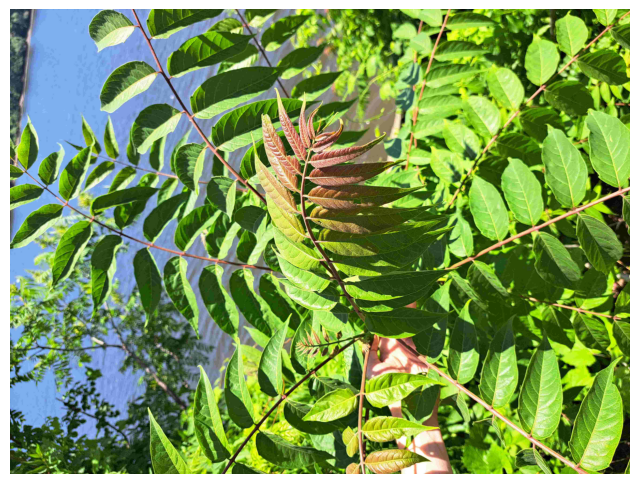

In [87]:
img = Image.open("20240605_125139.jpg") # Change the image name to identify different image identification
# Plot the image
plt.figure(figsize=(8, 8))  # Set figure size
plt.imshow(img)
plt.axis('off')  # Hide axes for better visualization
plt.show()

### Use your RapidAPI key for the iNaturalist VisionAPI in the code below

In [67]:
# Function to extract latitude and longitude from image EXIF data
def get_lat_lon(image_path):
    img = Image.open(image_path)
    exif_data = img.info.get('exif')
    
    if not exif_data:
        return None, None

    exif_dict = piexif.load(exif_data)

    def convert_to_degrees(value):
        d = float(value[0][0]) / float(value[0][1])
        m = float(value[1][0]) / float(value[1][1])
        s = float(value[2][0]) / float(value[2][1])
        return d + (m / 60.0) + (s / 3600.0)

    gps_info = exif_dict.get("GPS", {})
    if gps_info:
        gps_latitude = gps_info.get(piexif.GPSIFD.GPSLatitude)
        gps_latitude_ref = gps_info.get(piexif.GPSIFD.GPSLatitudeRef)
        gps_longitude = gps_info.get(piexif.GPSIFD.GPSLongitude)
        gps_longitude_ref = gps_info.get(piexif.GPSIFD.GPSLongitudeRef)

        if gps_latitude and gps_latitude_ref and gps_longitude and gps_longitude_ref:
            latitude = convert_to_degrees(gps_latitude)
            if gps_latitude_ref != b'N':
                latitude = -latitude

            longitude = convert_to_degrees(gps_longitude)
            if gps_longitude_ref != b'E':
                longitude = -longitude

            return latitude, longitude
    return None, None

# Function to identify species using iNaturalist VisionAPI
def identify_species(image_path, lat=None, lon=None):
    url = "https://visionapi.p.rapidapi.com/v1/rapidapi/score_image"
    headers = {
        "X-RapidAPI-Key": "Replace with your RapidAPI key for the iNaturalist VisionAPI", # Replace with your VisionAPI RapidAPI key 
        "X-RapidAPI-Host": "visionapi.p.rapidapi.com"
    }

    with open(image_path, 'rb') as image_file:
        files = {'image': image_file}
        data = {}
        if lat is not None and lon is not None:
            data['lat'] = lat
            data['lng'] = lon

        response = requests.post(url, headers=headers, files=files, data=data)
        
        if response.status_code == 200:
            return response.json()
        else:
            return f"Error: {response.status_code} - {response.text}"

# Extract latitude and longitude from image
lat, lon = get_lat_lon(image_path)

# Print extracted coordinates
if lat is not None and lon is not None:
    print(f"Extracted Coordinates - Latitude: {lat}, Longitude: {lon}")

# Identify the species
result = identify_species(image_path, lat, lon)

# Display the result
print(json.dumps(result, indent=4))

# Generate and display results with hyperlinks and view buttons
html_content = ""
for suggestive_species in result["results"]:
    scientific_name = suggestive_species['taxon']['name']
    taxon_id = suggestive_species['taxon']['id']
    common_name = suggestive_species['taxon'].get('preferred_common_name', 'Unknown').capitalize()
    url = f"https://www.inaturalist.org/taxa/{taxon_id}-{scientific_name.replace(' ', '-')}"

    html_content += f'''
        <div>
            <p>
                {common_name} (<a href="{url}" target="_blank">{scientific_name}</a>)
                <button onclick="window.open('{url}')">View</button>
            </p>
        </div>
    '''

# Display results in Jupyter Notebook
display(HTML(html_content))

Extracted Coordinates - Latitude: 42.65376059972222, Longitude: -73.7441034
{
    "results": [
        {
            "original_geo_score": 22.312527894973755,
            "original_combined_score": 93.18154483876813,
            "taxon": {
                "id": 57278,
                "name": "Ailanthus altissima",
                "preferred_common_name": "tree-of-heaven"
            },
            "seen_nearby": true,
            "visually_similar": true
        },
        {
            "original_geo_score": 27.900665998458862,
            "original_combined_score": 3.606393420808117,
            "taxon": {
                "id": 54504,
                "name": "Juglans nigra",
                "preferred_common_name": "eastern black walnut"
            },
            "seen_nearby": true,
            "visually_similar": true
        },
        {
            "original_geo_score": 7.7850885689258575,
            "original_combined_score": 1.838995978304931,
            "taxon": {
          